# 아이유 얼굴에 고양이 수염 스티커를 자동으로 넣어보자


### 1.주요한 점들
### 2.이미지 불러오기
### 3.이미지에서 얼굴부분 찾아내기(face detection)
### 4.얼굴 이미지 특징 추출하기(face landmark)
### 5.스티커 붙히기

## 1. 주요한 점들

#### 1)Detector_hog   #face detector
- input : image
- output : 얼굴 윤곽 그라디언트 각 좌표들
- for 문 처리 후 : bounding box 의 left, right, top, bottom

#### 2)Dlib landmark localization
- input : face image
- output : face 주요 랜드마크(ex 입끝) 68개의 좌표값
- for 문 처리 후 : 68 개의 list 값을 return
 
#### 3)얼굴의 기울기 구하는 방법
- 목표 : 코 시작점(27번째) - 코 끝점(31번째) 의 dy/dx 의 arctan 값
+ 90도(코가 수직 위치여야 얼굴이 바른 것)
+ 모든 각도가 radian 이기 때문에 도<=>라디안 변환 잘 해줄 것

#### 4)스티커 붙힐 위치
- 목표 : 아이유 얼굴의 코끝에 고양이 코 스티커를 위치시킨다
- x 좌표 : 아이유 코 끝 x 좌표 - 스티커 너비/2
- y 좌표 : 아이유 코 끝 y 좌표 - 스티커 높이/2
 
#### 5)스티커 사이즈 변환
- 원래 스티커 사이즈는 너무 작다.
- resize 했을때 얼굴에 꽉 차면 가장 이쁘지 않을까? 해서
- face detection box 의 크기로 resize 함.
+ 문제가 생김 : 얼굴 각도로 스티커를 회전시키게 되면 검은색 빈 공간이 생긴다.
+ 이로 인해 얼굴사이즈 보다 1.2배 확대하여 적용하였다.

#### 6)스티커 붙히는 방법
- 아이유 전체 사진 중 얼굴만의 영역의 x,y,w,h 를 구한다
- 스티커를 w,h로 resize 된 스티커 이미지를 
- 스티커 붙힐 영역(아이유 얼굴영역[y:y+h, x:x+w], sticker_area) 에 붙히면 끝.

In [25]:
# 패키지 설정

#!pip install opencv-python cmake dlib
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import os

In [26]:
# 경로설정

home_path = os.getenv('HOME')
sticker_path = home_path + '/aiffel/exp/exp3_camera_sticker/stickers/'   # sticker image path
model_path = home_path + '/aiffel/exp/exp3_camera_sticker/models/shape_predictor_68_face_landmarks.dat'   # face detection model path
image_path = home_path + '/aiffel/exp/exp3_camera_sticker/images/'  # my face image path

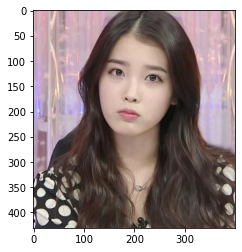

In [27]:
# image setting

iu_path = image_path + 'iu.jpeg'  # iu image path
iu_image = cv2.imread(iu_path, cv2.COLOR_BGR2RGB)
iu_image = cv2.cvtColor(iu_image, cv2.COLOR_BGR2RGB)
img_show = iu_image.copy()

plt.imshow(img_show)
plt.show()

## 얼굴 검출, 박스 설정

box info :  (115, 81) (270, 236) size :  (155, 155)


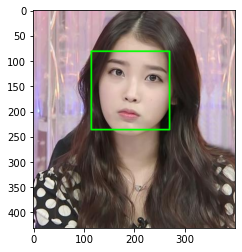

In [28]:
# face detection

# face detector set
detector_hog = dlib.get_frontal_face_detector()   # detector 선언
dlib_rects = detector_hog(img_show, 1)
#print(dlib_rects)    # rectangles[[(115, 81) (270, 236)]]

# set face bounding box

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

# set bounding box
#iu_box_image = cv2.imread(iu_path, cv2.IMREAD_COLOR)
iu_box_img = img_show.copy()
cv2.rectangle(iu_box_img, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
iu_face_box_left_top = (l, t)
iu_face_box_size = (r-l, b-t)
print("box info : ", (l,t), (r,b), "size : ", iu_face_box_size)

# image show
plt.imshow(iu_box_img)
plt.show()

## 랜드마크 검출

(194, 169)


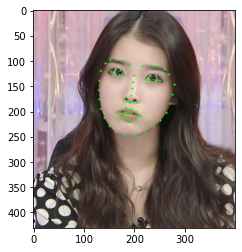

In [29]:
#  landmark detector 

# set landmark model
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_show, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

#print(len(list_landmarks[0]))
print(list_landmarks[0][30])   # 코 위치 (194, 169)

# 아이유 얼굴에 각 랜드카크 표시하기
iu_image_pointed = img_show.copy() #cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(iu_image_pointed, point, 2, (0, 255, 0), -1) 

plt.imshow(iu_image_pointed)
plt.show()

## 얼굴 기울기 구하기

In [30]:
# 코의 기울기를 통해서 얼굴의 기울기를 알아보자

#landmark 27~30
delta_x = list_landmarks[0][30][0] - list_landmarks[0][27][0]
delta_y = list_landmarks[0][30][1] - list_landmarks[0][27][1]
print(delta_x, delta_y)    # -6 40

angle = np.arctan(delta_y / delta_x) * (180/np.pi)
angle = angle//1
print(angle)   # -81.46923439005187
angle = angle + 90
print(angle)  # 8.530765609948133 우측으로 8.5도 기울어짐

-6 40
-82.0
8.0


In [31]:
# 이 방법은 버림

# 고양이 수염을 어디에 그릴까?
# 가로 : 코 양쪽 볼(0 ~ 16)
# 세로 : 코 ~ 아랫잎술 (30 ~ 57)
# 수염 사이즈는 어떻게 되나?

kitty_sticker_x = list_landmarks[0][0][0]
kitty_sticker_y = list_landmarks[0][0][1]
kitty_sticker_width = list_landmarks[0][16][0] - list_landmarks[0][0][0]
kitty_sticker_height = list_landmarks[0][57][1] - list_landmarks[0][30][1]

print(kitty_sticker_x, kitty_sticker_y)
print(kitty_sticker_width, kitty_sticker_height)

134 120
146 47


## 스티커 사진 resize

#### 1) 스티커 사진 준비
#### 2) 스티커 사진 resize
#### 3) 스티커 사진 회전(얼굴 기울기)

In [32]:
# 고양이 스티커 사이즈 resize 

kitty_sticker_path = sticker_path + 'kitty.png'
kitty_sticker = cv2.imread(kitty_sticker_path, cv2.IMREAD_COLOR)
print(kitty_sticker.shape)   # (63, 63, 3) 

# 고양이 편집 스티커 사이즈 조절 >> 얼굴 사이즈로 확대

#resize_size = (iu_face_box_size[0], iu_face_box_size[1])
resize_size = iu_face_box_size
kitty_sticker_image_resized = cv2.resize(kitty_sticker, resize_size)
print(kitty_sticker_image_resized.shape)   # (155, 155, 3)

# rotate 고양이 스티커 이미지 https://076923.github.io/posts/Python-opencv-6/
matrix = cv2.getRotationMatrix2D((kitty_sticker_image_resized.shape[0]//2, kitty_sticker_image_resized.shape[1]//2), -angle, 1.2) #abs(1/np.cos(-angle*180/np.pi)))
kitty_sticker_image_resized = cv2.warpAffine(kitty_sticker_image_resized, matrix, (kitty_sticker_image_resized.shape[0], kitty_sticker_image_resized.shape[1]))

(512, 512, 3)
(155, 155, 3)


## 스티커 붙히기

#### 1)기존방식
#### 2)addWeighted 방식

(155, 155, 3)


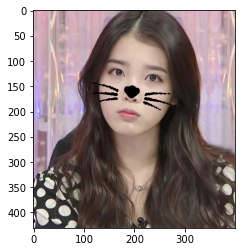

In [40]:
# 스티커 시작 위치, 크기 정리

iu_kitty = iu_image.copy()

x_s = list_landmarks[0][30][0] - kitty_sticker_image_resized.shape[0]//2
x_e = x_s + kitty_sticker_image_resized.shape[0]
y_s = list_landmarks[0][30][1] - kitty_sticker_image_resized.shape[1]//2
y_e = y_s + kitty_sticker_image_resized.shape[1]

sticker_area = iu_kitty[y_s:y_e, x_s:x_e]
print(sticker_area.shape)

iu_kitty[y_s:y_e, x_s:x_e] = \
    np.where(kitty_sticker_image_resized!=0, sticker_area, kitty_sticker_image_resized).astype(np.uint8)

plt.imshow(iu_kitty)
plt.show()

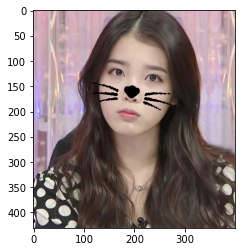

In [42]:
# 2) addWeighted 방식 - 흰색 배경이 안 없어진다.

iu_kitty_addweighted = iu_image.copy()

mixture_ratio = 0.5
#iu_kitty_addweighted[y_s:y_e, x_s:x_e] = cv2.addWeighted(sticker_area, mixture_ratio, kitty_sticker_image_resized, 1-mixture_ratio, 0)
iu_kitty_addweighted[y_s:y_e, x_s:x_e] = cv2.addWeighted(sticker_area, 1, kitty_sticker_image_resized, 0, 0)

plt.imshow(iu_kitty_addweighted)
plt.show()